In [2]:
# for development only

%load_ext autoreload
%autoreload 2

In [3]:
import cnmfsns as cn
cn.start_logging()

## Working with `Dataset` objects

Datasets can be created from pandas DataFrames quite easily.

In [4]:
import pandas as pd

data = pd.read_table("diamandis_data/diamandis_nobulk.txt", index_col=0)  # normalized expression data
metadata = pd.read_table("diamandis_data/diamandis_nobulk.metadata.txt", index_col=0)  # sample metadata

# create dataset from DataFrames
diamandis = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col="patient_id")

They can be written to and read from AnnData files (h5ad format).

In [5]:
diamandis.write_h5ad("diamandis.h5ad")  # write to .h5ad file
diamandis = cn.Dataset.from_h5ad("diamandis.h5ad", patient_id_col="patient_id")  # read a .h5ad file

2023-04-19 08:07:31,691 [INFO] Writing to /home/tbverhey/github/cNMF-SNS/tutorial/diamandis.h5ad
2023-04-19 08:07:31,735 [INFO] Done


`Dataset` objects contain an AnnData object which can also be used for interfacing with other tools

In [6]:
diamandis.adata

AnnData object with n_obs × n_vars = 77 × 3560
    obs: 'patient_id', 'simple_category', 'detailed_category', 'age', 'sex', 'location of resection', 'ATRX', 'p53', 'MGMT'
    uns: 'cnmfsns_version', 'history', 'is_normalized', 'odg'

cNMF-SNS can recognize and import AnnData .h5ad files whether they are created in [Seurat](https://satijalab.org/seurat/archive/v2.4/conversion_vignette.html), [scanpy](https://scanpy.readthedocs.io/en/stable/usage-principles.html#anndata), or other single-cell software tools.

In [7]:
import scanpy

pbmc_adata = scanpy.datasets.pbmc3k()
pbmc_dataset = cn.Dataset.from_anndata(pbmc_adata)

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

## Modelling mean and dispersion of genes

In [8]:
diamandis.compute_gene_stats()
diamandis.adata.var.head()  # results are stored in dataset object

,mean,rank_mean,variance,sd,missingness,log_mean,log_variance,mean_counts,odscore_excluded,resid_log_variance,odscore,gam_fittedvalues,vscore
A1BG,1.839333e+07,2152.0,1.787097e+14,1.336824e+07,0.0,7.264660,14.252150,1.839333e+07,False,0.090640,1.109992,14.161510,1.621348
A2M,2.338366e+08,3351.0,2.278611e+16,1.509507e+08,0.0,8.368914,16.357672,2.338366e+08,False,0.040062,1.047204,16.317609,4.806647
AAAS,2.478940e+06,203.0,9.438756e+11,9.715326e+05,0.0,6.394266,11.974916,2.478940e+06,False,-0.186994,0.806312,12.161910,0.077113
AAK1,1.713328e+07,2096.0,2.520759e+14,1.587690e+07,0.0,7.233840,14.401531,1.713328e+07,False,0.294975,1.404389,14.106556,2.489859
AARS1,1.069756e+08,3146.0,9.684864e+14,3.112051e+07,0.0,8.029285,14.986094,1.069756e+08,False,-0.652043,0.472040,15.638138,0.763087


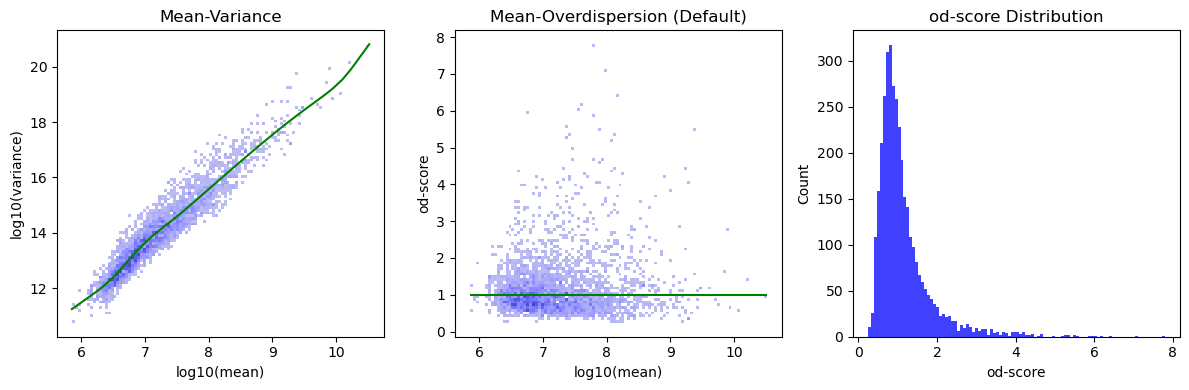

In [9]:
figs = cn.plot_feature_dispersion(diamandis)

## Selecting overdispersed genes

2023-04-19 08:07:39,265 [INFO] 1612 genes selected for factorization


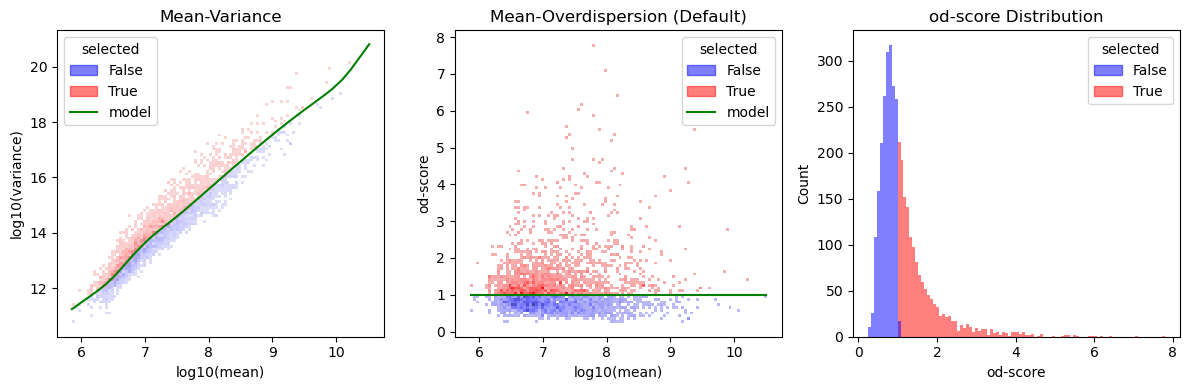

In [10]:
diamandis.select_overdispersed_genes()
figs = cn.plot_feature_dispersion(diamandis, show_selected=True)

Default parameters for `select_overdispersed_genes()` results in about 50% of genes as being overdispersed:

In [11]:
diamandis.adata.var["selected"].value_counts()

False    1948
True     1612
Name: selected, dtype: int64

## Factorization

In [12]:
cnmf_results_dir = "cnmf_results"
run_name = "diamandis"
# by default, k=2-60 is run with n_iter=200. For this demo, we will speed it up by drastically subsetting.
kvals = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
kvals = [2, 3 ,4, 5, 6, 7, 8]
n_iter = 10

cnmf_run = diamandis.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)

cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
diamandis.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
diamandis.write_h5ad("diamandis.h5ad")  # overwrite original file

2023-04-19 08:07:47,534 [INFO] Factorization outputs (individual iterations) were found for all values of k. No missing files were detected.
2023-04-19 08:07:47,535 [INFO] Merging iterations for k=2
2023-04-19 08:07:47,540 [INFO] Combining factorizations for k=2.
2023-04-19 08:07:47,586 [INFO] Merging iterations for k=3
2023-04-19 08:07:47,591 [INFO] Combining factorizations for k=3.
2023-04-19 08:07:47,642 [INFO] Merging iterations for k=4
2023-04-19 08:07:47,645 [INFO] Combining factorizations for k=4.
2023-04-19 08:07:47,697 [INFO] Merging iterations for k=5
2023-04-19 08:07:47,700 [INFO] Combining factorizations for k=5.
2023-04-19 08:07:47,758 [INFO] Merging iterations for k=6
2023-04-19 08:07:47,762 [INFO] Combining factorizations for k=6.
2023-04-19 08:07:47,824 [INFO] Merging iterations for k=7
2023-04-19 08:07:47,827 [INFO] Combining factorizations for k=7.
2023-04-19 08:07:47,893 [INFO] Merging iterations for k=8
2023-04-19 08:07:47,896 [INFO] Combining factorizations for k=8

## Stability-Error Plot

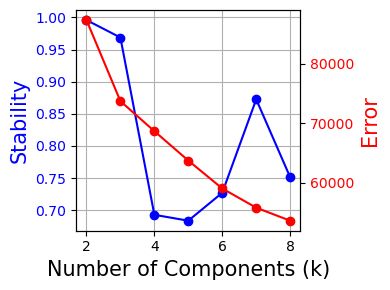

In [13]:
fig = cn.plot_stability_error(diamandis, figsize=[4,3])

fig.savefig("stability-error.pdf")  # Save figures in PDF or PNG format

## Plot GEP usage

In [14]:
diamandis.get_usages()

2                       3                          \
                   1           2           1           2           3   
sample_1   286218.03  68102.7000  275644.660  50335.7660   37250.766   
sample_10  275317.44  43158.7660  222617.310  29782.0700   69662.060   
sample_11  303999.53  47125.1760  314790.160  30743.0780   18382.818   
sample_12  325225.66  25386.7500  352012.940   8527.1875    6471.699   
sample_13  322568.72  10299.3110  270664.700   2540.7021   65501.562   
...              ...         ...         ...         ...         ...   
sample_75  381411.72   4519.2285   13208.699   2133.1843  338616.400   
sample_76  340750.72   7925.2256   62412.580   4160.6610  259924.140   
sample_77  375924.60   5567.8247   26877.764   3814.2825  320897.120   
sample_8   295992.10  25950.8500  304261.400  10744.7850   19732.504   
sample_9   353186.06  24188.1760  359219.100  10149.1090   22501.184   

                    4                                                 5  ...  \
                    1           2            3            4           1  ...   
sample_1   223278.020  36484.7770   25592.7190   83363.6900  205121.440  ...   
sample_10  175515.600  18497.7460   56528.1200   80315.1400  101161.914  ...   
sample_11  293028.440  29387.0660   10351.9510   15975.2260   40239.473  ...   
sample_12  330198.620   9834.2290    1873.6380    6883.4526  272681.780  ...   
sample_13  249647.780   1418.2328   54672.6370   25129.0780  105897.400  ...   
...               ...         ...          ...          ...         ...  ...   
sample_75   25024.834   1259.3590  323614.6200    3657.8962   12154.561  ...   
sample_76   67806.220   1897.9371  240727.3600   17391.1230   27036.158  ...   
sample_77   42113.273   2295.8680  300877.6000    6403.0654   10516.070  ...   
sample_8   212228.980   1040.4066    7465.0605  132672.0800  196275.640  ...   
sample_9   340221.250  11382.4740   14223.1810    7721.9824   64164.035  ...   

                     7                         8                            \
                     6           7             1            2            3   
sample_1    52632.4920   7073.7920  33282.010000   53051.7300  204036.4000   
sample_10   21722.8160   1615.9811  15165.008000   39814.3900  160684.2200   
sample_11   26639.7600   6027.6890  27630.303000  212712.1100   18201.7300   
sample_12  259591.7500   3213.2546   3253.982200   53914.6800   13147.8970   
sample_13   28054.3090   2155.6184    732.959200  140696.7500   80917.6300   
...                ...         ...           ...          ...          ...   
sample_75    5179.4053   1666.3450   1405.505100   20676.6390    6384.8774   
sample_76    7185.8590    950.8377   1409.908100   38868.2300   56607.5270   
sample_77    6227.5750   1232.7479     44.846508    1940.6833    1776.4749   
sample_8    27980.4200  14705.7530   1408.768700   70742.6000  233423.8800   
sample_9    72279.8400   3663.3480   9502.267000  247525.7300   13183.8720   

                                                                             
                      4           5             6             7           8  
sample_1    10596.60500  38345.7660   44800.29300   10416.01500  4467.72600  
sample_10   16723.47700   9435.0400   12425.87000   95448.67000  1470.76390  
sample_11    8084.63960  18092.8630   23509.59800   29287.91000  4414.12700  
sample_12     934.11005  13736.7020  254292.08000     133.68094  2314.46730  
sample_13   45798.53000  40515.5300   24612.90600    6142.69970  1207.43870  
...                 ...         ...           ...           ...         ...  
sample_75  295705.03000  22567.5330    4691.19430    3866.32740  1420.09050  
sample_76  216441.95000   4441.0713    5705.06740   16428.96500   688.46080  
sample_77  226272.58000   2555.6123     733.18317  118526.10000   351.59482  
sample_8      729.53326  44347.0470   20391.95000     164.77104  9120.99800  
sample_9    15173.86800   9989.0520   69145.91000     985.19763  1924.02080  

[77 rows x 

2023-04-19 08:08:18,267 [INFO] Choosing distinct colors for metadata layer patient_id
2023-04-19 08:08:18,487 [INFO] Choosing distinct colors for metadata layer simple_category
2023-04-19 08:08:18,518 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-04-19 08:08:18,551 [INFO] Choosing distinct colors for metadata layer sex
2023-04-19 08:08:18,563 [INFO] Choosing distinct colors for metadata layer location of resection
2023-04-19 08:08:18,712 [INFO] Choosing distinct colors for metadata layer ATRX
2023-04-19 08:08:18,728 [INFO] Choosing distinct colors for metadata layer p53
2023-04-19 08:08:18,747 [INFO] Choosing distinct colors for metadata layer MGMT


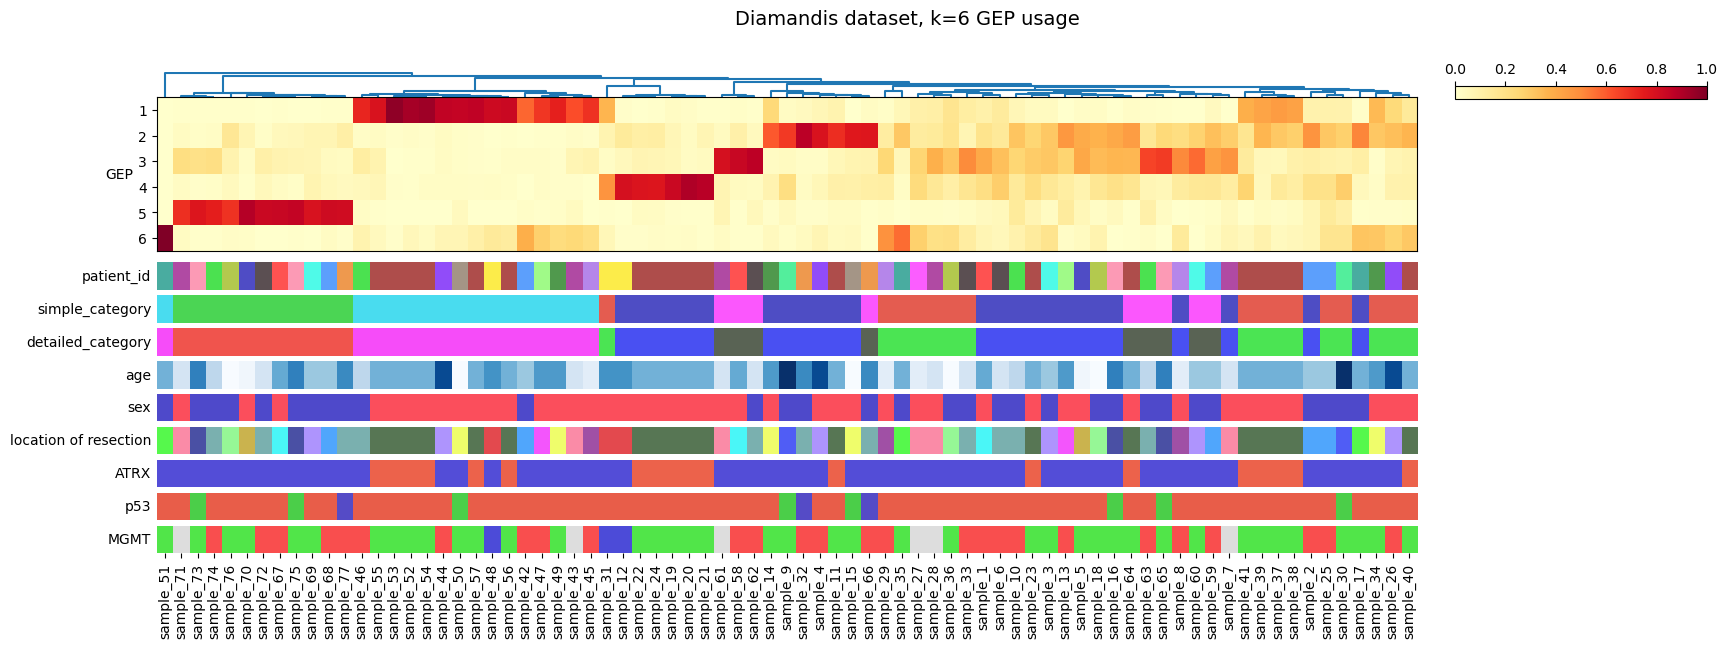

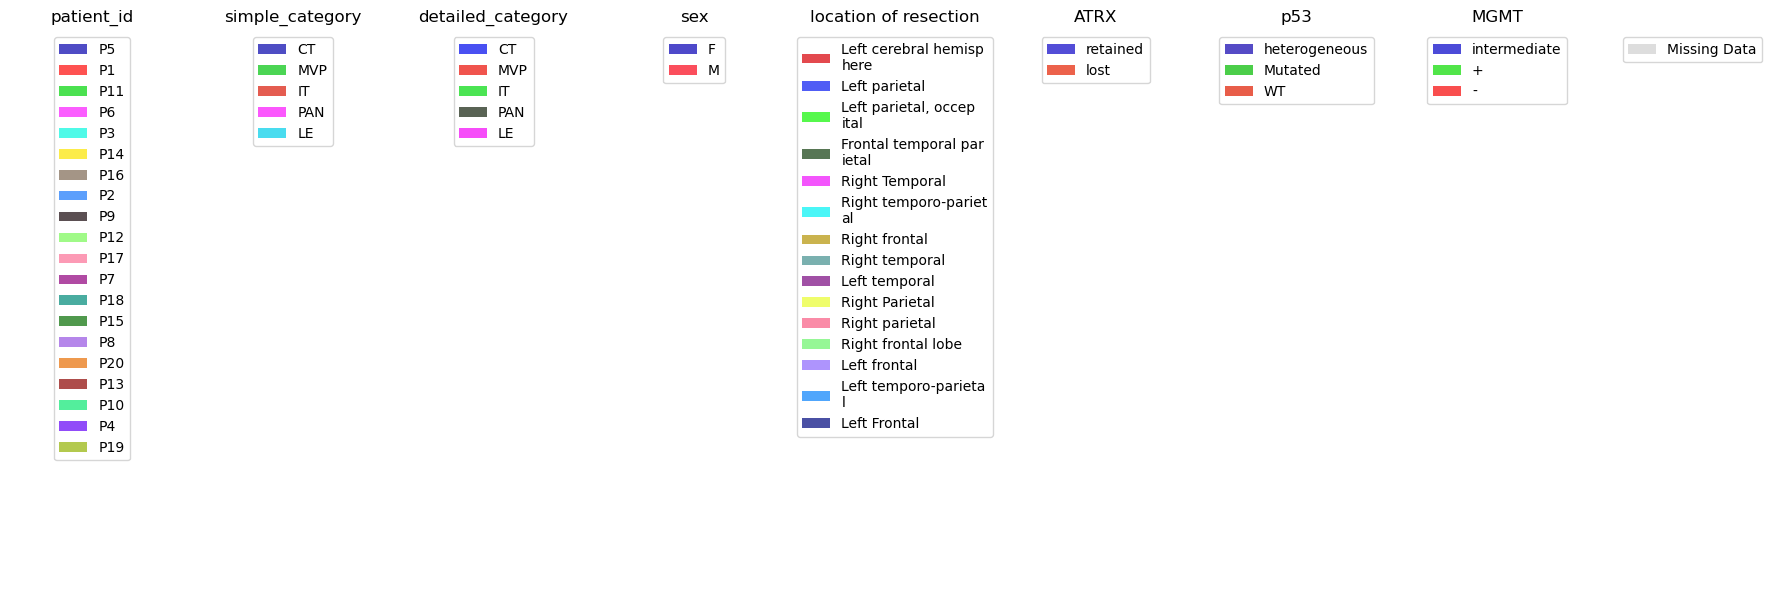

In [15]:
colors = cn.Colors.from_dataset(diamandis, pastel_factor=0.4)  # create distinct colors for metadata tracks


fig = cn.plot_usage_heatmap(diamandis, k=6, colors=colors,
                                     title="Diamandis dataset, k=6 GEP usage")
fig.savefig("k6_usages_heatmap.pdf")

fig_legend = colors.plot_metadata_colors_legend()
fig.savefig("diamandis_metadata_colors_legend.pdf")

## Factorize a second dataset for integration

In [16]:
data = pd.read_csv("cptac_data/cptac_gbm.csv", index_col=0).T  # normalized expression data
metadata = pd.read_table("cptac_data/cptac_gbm.metadata.txt", index_col=0)  # sample metadata

# create dataset from CPTAC example data
cptac = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col = "patient_id")
cptac.compute_gene_stats()
cptac.select_overdispersed_genes()

# creates directory with cNMF results
cnmf_results_dir = "cnmf_results"
run_name = "cptac"
cnmf_run = cptac.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)
cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
cptac.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
cptac.write_h5ad("cptac.h5ad")  # write to h5ad file

2023-04-19 08:08:26,014 [INFO] 4554 genes selected for factorization
2023-04-19 08:10:44,516 [INFO] Factorization outputs (individual iterations) were found for all values of k. No missing files were detected.
2023-04-19 08:10:44,519 [INFO] Merging iterations for k=2
2023-04-19 08:10:44,536 [INFO] Combining factorizations for k=2.
2023-04-19 08:10:44,765 [INFO] Merging iterations for k=3
2023-04-19 08:10:44,773 [INFO] Combining factorizations for k=3.
2023-04-19 08:10:44,990 [INFO] Merging iterations for k=4
2023-04-19 08:10:44,997 [INFO] Combining factorizations for k=4.
2023-04-19 08:10:45,174 [INFO] Merging iterations for k=5
2023-04-19 08:10:45,180 [INFO] Combining factorizations for k=5.
2023-04-19 08:10:45,369 [INFO] Merging iterations for k=6
2023-04-19 08:10:45,374 [INFO] Combining factorizations for k=6.
2023-04-19 08:10:45,559 [INFO] Merging iterations for k=7
2023-04-19 08:10:45,565 [INFO] Combining factorizations for k=7.
2023-04-19 08:10:45,776 [INFO] Merging iterations fo

## Integrate multiple datasets together

In [17]:
datasets = {"CPTAC": cptac,
            "Diamandis": diamandis}
integration = cn.Integration(datasets=datasets)  # create an integration object
colors = cn.Colors.from_integration(integration)  # create color scheme for metadata and datasets
colors.to_toml("colors.toml")  # save to file for reference (TOML file can be re-imported)

2023-04-19 08:11:35,217 [INFO] nancorrmp found. Calculating Pearson correlation matrix using 16 CPUs.
2023-04-19 08:11:35,629 [INFO] Choosing distinct dataset colors
2023-04-19 08:11:35,658 [INFO] Choosing distinct colors for metadata layer patient_id
2023-04-19 08:11:42,532 [INFO] Choosing distinct colors for metadata layer simple_category
2023-04-19 08:11:42,551 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-04-19 08:11:42,575 [INFO] Choosing distinct colors for metadata layer multiomic
2023-04-19 08:11:42,602 [INFO] Choosing distinct colors for metadata layer r_wang_cancer_cell_2017
2023-04-19 08:11:42,634 [INFO] Choosing distinct colors for metadata layer d_methyl
2023-04-19 08:11:42,682 [INFO] Choosing distinct colors for metadata layer d_methyl_mnp
2023-04-19 08:11:42,769 [INFO] Choosing distinct colors for metadata layer is_gcimp
2023-04-19 08:11:42,781 [INFO] Choosing distinct colors for metadata layer immune
2023-04-19 08:11:42,806 [INFO] Choosing di

In [18]:
integration.k_subset

(2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60)

Identify gene overlap between datasets

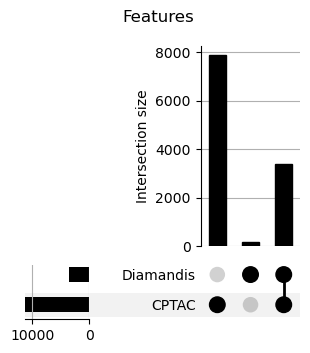

In [19]:
cn.plot_features_upset(integration)

A subset of these are identified as overdispersed in each dataset, and there is a significant overlap between datasets, indicating similar variation is seen in the two separate datasets.

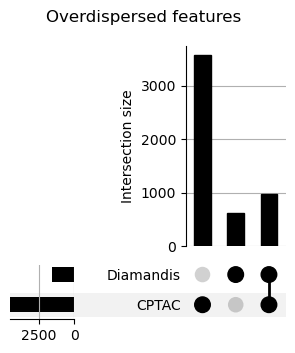

In [20]:
cn.plot_overdispersed_features_upset(integration)

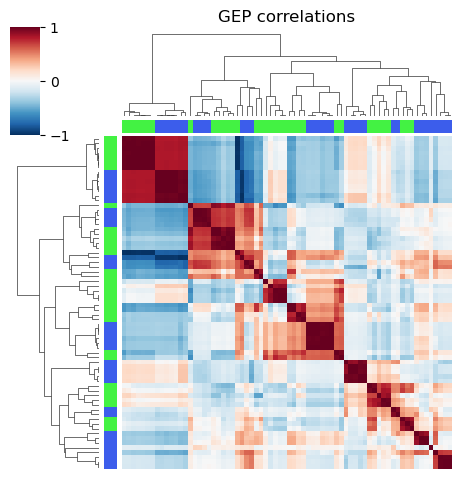

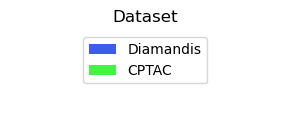

In [21]:
# plot the correlation matrix of all GEPs to each other
fig = cn.plot_gep_correlation_matrix(integration, colors=colors, figsize=[6, 6], hide_gep_labels=True)
fig.savefig("correlation_matrix.pdf")

# plot the legend separately as it applies to multiple figures
figlegend = colors.plot_dataset_colors_legend()
figlegend.savefig("datasets_legend.pdf")

To see if the `max_median_corr` threshold removed any ranks from either of the datasets, the following plot can be generated. The x-axis is the max-k, a threshold that excludes ranks above. The y-axis is the median of the correlation coefficients for all non-self edges in the correlation network. As this this threshold is slowly increased, the number of ranks, and thus nodes, and thus edges increases. The correlation between all edges slowly increases. In some datasets, this median of correlations will exceed 0 at high ranks. These high ranks will be excluded by this filter.

You can easily see for each rank whether there is a cNMF result, the stability/error of the result, as well as whether the ranks will be excluded on the basis of a max-k filter (derived from the max_median_corr parameter). You can also see which ranks will be selected (selected_k) based on automatic node subsetting for the final SNS maps.

In [22]:
integration.k_table

CPTAC                                                                  \
  cNMF result max_k_filter_pass max_k_median_corr prediction_error selected_k   
2        True              True         -0.991516    297196.843750       True   
3        True              True         -0.476640    271760.687500       True   
4        True              True         -0.352260    255798.218750       True   
5        True              True         -0.190609    241305.093750       True   
6        True              True         -0.147560    232329.640625       True   
7        True              True         -0.134573    226881.156250       True   
8        True              True         -0.146421    221939.640625       True   

              Diamandis                                                       \
  stability cNMF result max_k_filter_pass max_k_median_corr prediction_error   
2  0.991785        True              True         -0.999228     87355.242188   
3  0.892531        True              True         -0.452203     73724.257812   
4  0.665489        True              True         -0.203645     68684.937500   
5  0.730236        True              True         -0.156310     63740.625000   
6  0.670961        True              True         -0.128741     59053.246094   
7  0.489825        True              True         -0.121356     55824.882812   
8  0.401975        True              True         -0.114330     53642.183594   

                        
  selected_k stability  
2       True  0.995913  
3       True  0.968658  
4       True  0.692752  
5       True  0.683609  
6       True  0.727040  
7       True  0.872450  
8       True  0.751299

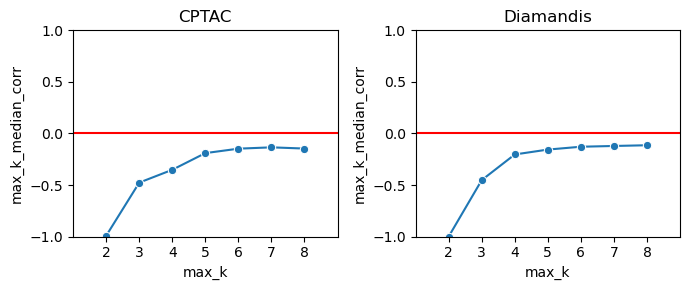

In [23]:
fig = cn.plot_rank_reduction(integration)

You can see that no k-values exceeded the threshold, so no max_k filter was applied. Now, let's plot the distribution of correlations for GEPs within and between datasets. This will show the min_corr thresholds. There is one threshold per dataset pair, and one threshold for within each dataset.

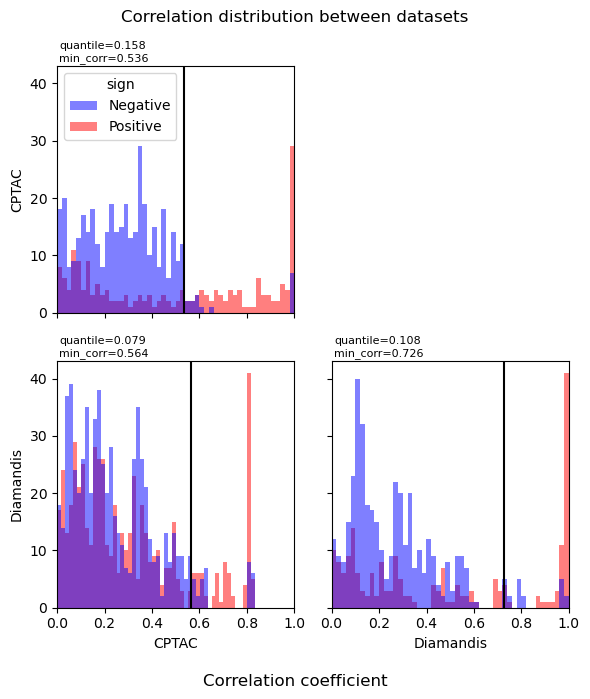

In [24]:
# fig = cn.plot_pairwise_corr(integration)
fig2 = cn.plot_pairwise_corr_overlaid(integration)  # overlaid plots show the mirrored distributions

See the number of nodes from each dataset with and without the node filters (including maxk and selectedk filters) and the edge filter (min_corr thresholds).

In [25]:
integration.get_node_table()

Node filter none         maxk         selectedk        
Edge Filter none mincorr none mincorr      none mincorr
CPTAC         35      35   35      35        35      35
Diamandis     35      35   35      35        35      35

## Create an SNS integration

2023-04-19 08:11:48,851 [INFO] Community search: algorithm = greedy_modularity, resolution = 1
2023-04-19 08:11:48,862 [INFO] Creating community network


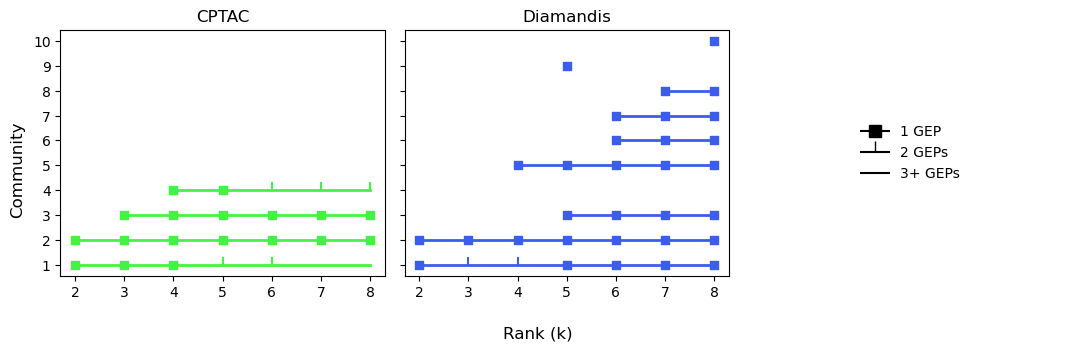

In [26]:
snsmap = cn.SNS(integration)
snsmap.community_search(algorithm="greedy_modularity", resolution=1)
fig = cn.plot_community_by_dataset_rank(snsmap, colors)

## Prune communities with only 1 node

2023-04-19 08:11:49,689 [INFO] Creating community network


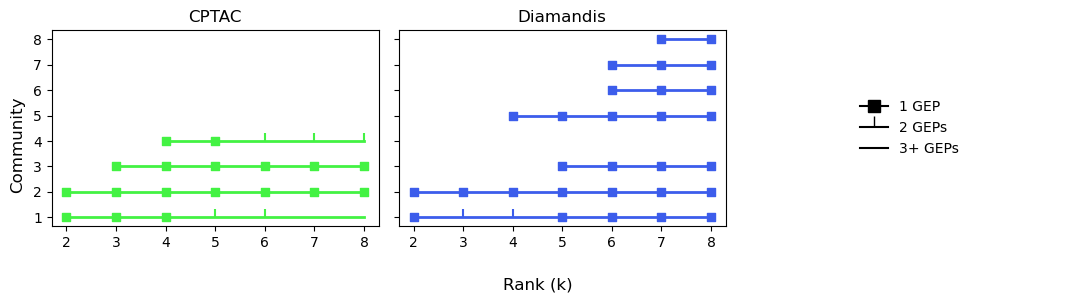

In [27]:
snsmap.prune_communities(min_nodes = 2)
fig = cn.plot_community_by_dataset_rank(snsmap, colors)

## Save SNS object and underlying data

In [28]:
snsmap.to_pkl("sns.pkl")

# to read it back, use this
snsmap = cn.SNS.from_pkl("sns.pkl")

# Plot an SNS Map

2023-04-18 14:09:38,146 [INFO] Computing community layout using spring method.


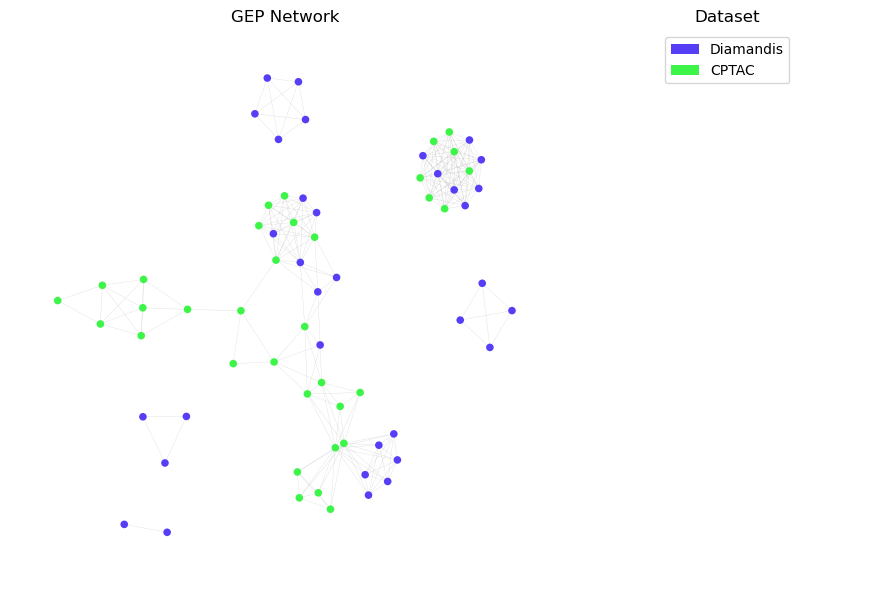

In [51]:
snsmap.compute_layout(algorithm="neato")  # available algorithms: "community_weighted_spring", "spring", "neato"
fig = cn.plot_gep_network_datasets(snsmap, colors, node_size_kval=False)

How many samples have each GEP/node as their highest usage GEP? 

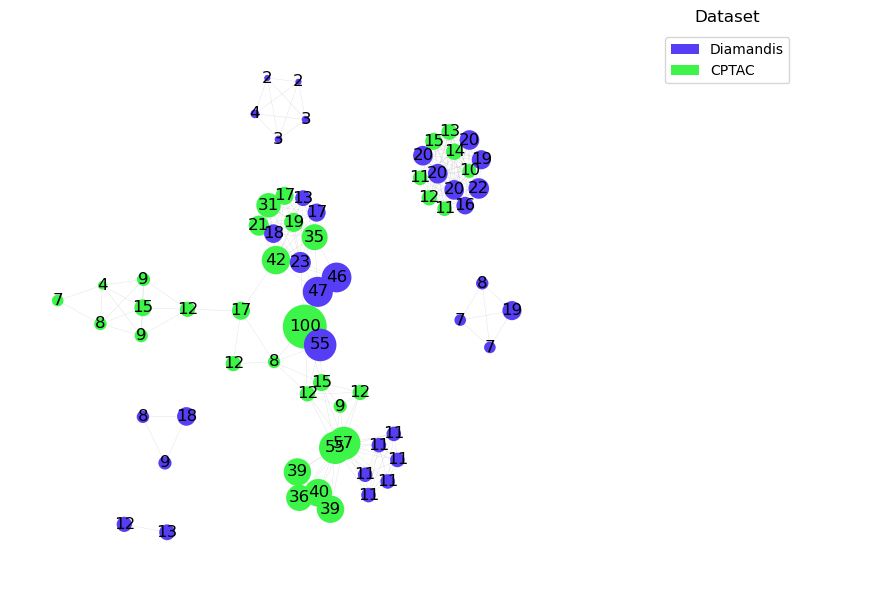

In [52]:
fig = cn.plot_gep_network_nsamples(snsmap,
                                  colors,
                                  node_size=1e3,
                                  font_size=12,
                                  discretize=True)

How many patients is each GEP primarily associated to?

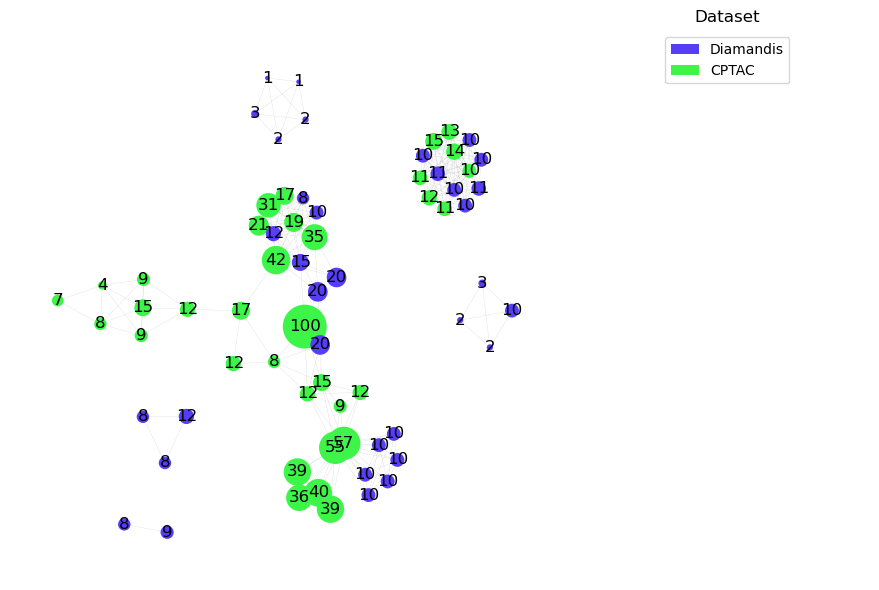

In [46]:
fig = cn.plot_gep_network_npatients(snsmap, colors, node_size=1e3, font_size=12)


Overrepresentation of sample categories for each GEP on the network

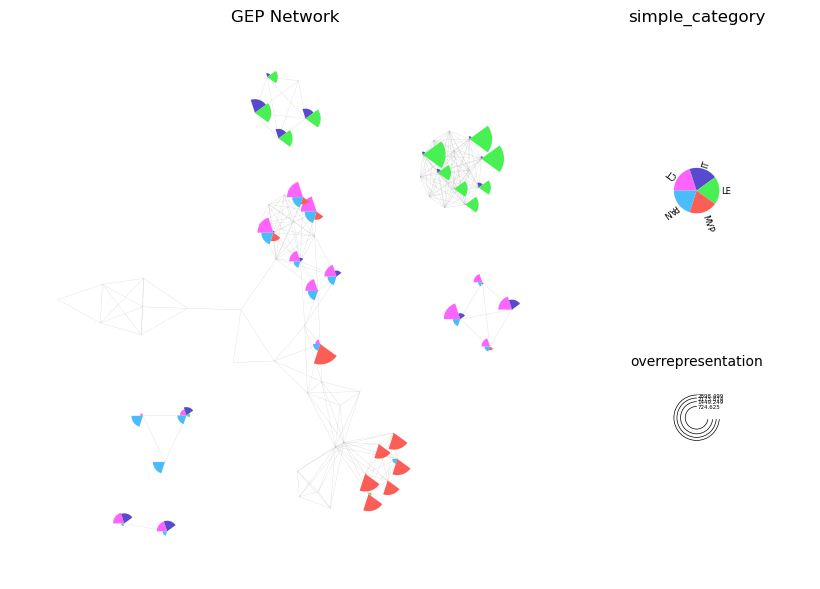

In [47]:
fig = cn.plot_overrepresentation_gep_network(snsmap, colors, subset_datasets="Diamandis", layer="simple_category")
fig.savefig("diamandis_overrepresentation.pdf")

And again, using the CPTAC annotations

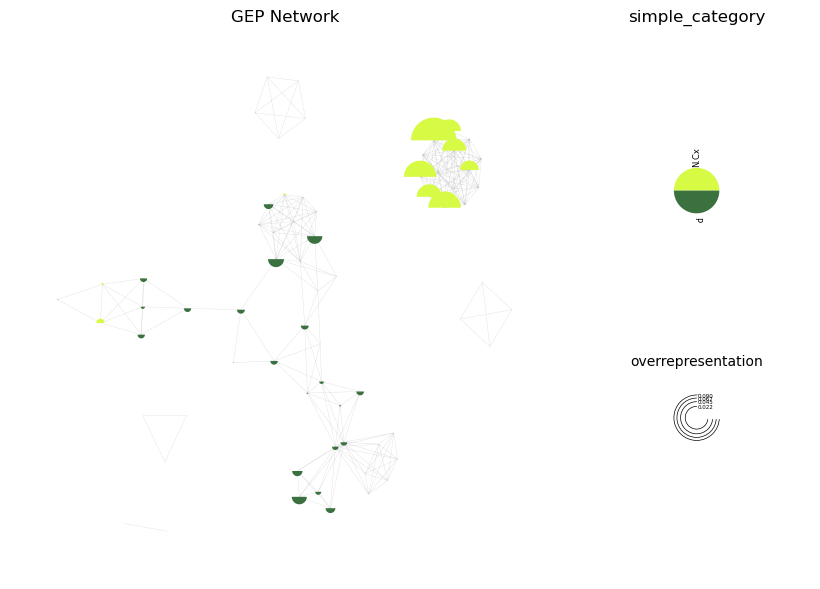

In [48]:
fig = cn.plot_overrepresentation_gep_network(snsmap, colors, subset_datasets="CPTAC", layer="simple_category")
fig.savefig("cptac_overrepresentation.pdf")

You can also look at continuous metadata correlated with GEP usage, like age:

# Identifying GEP Communities

2023-04-18 09:15:23,773 [INFO] Choosing distinct community colors


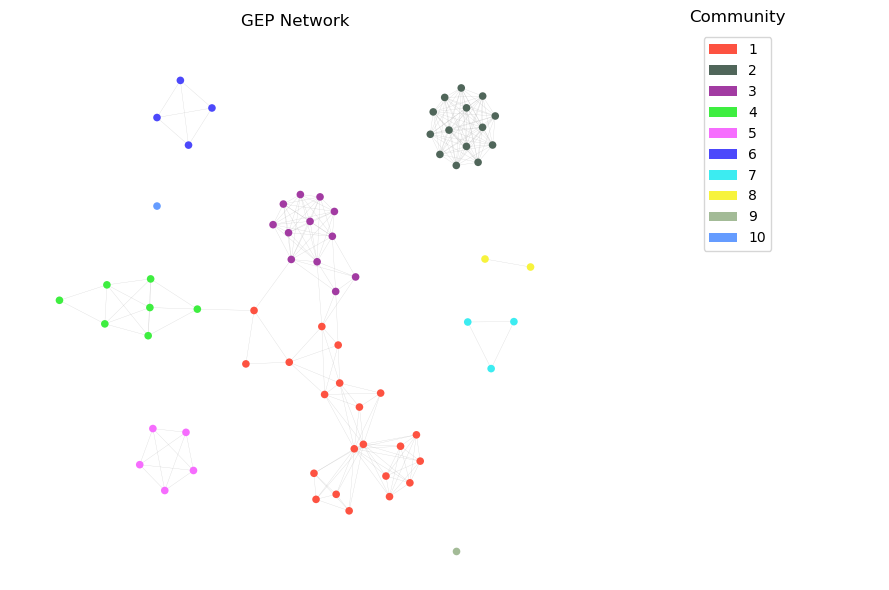

In [31]:
colors.add_missing_community_colors(snsmap)
fig = cn.plot_gep_network_communities(snsmap, colors)

Plot a summary showing the size of each community (node size) and number of edges connecting communities (edge width).

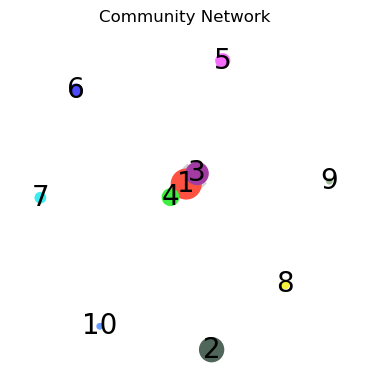

In [32]:
fig = cn.plot_summary_community_network(snsmap, colors)

Plot GEP usage heatmap summarized by Community

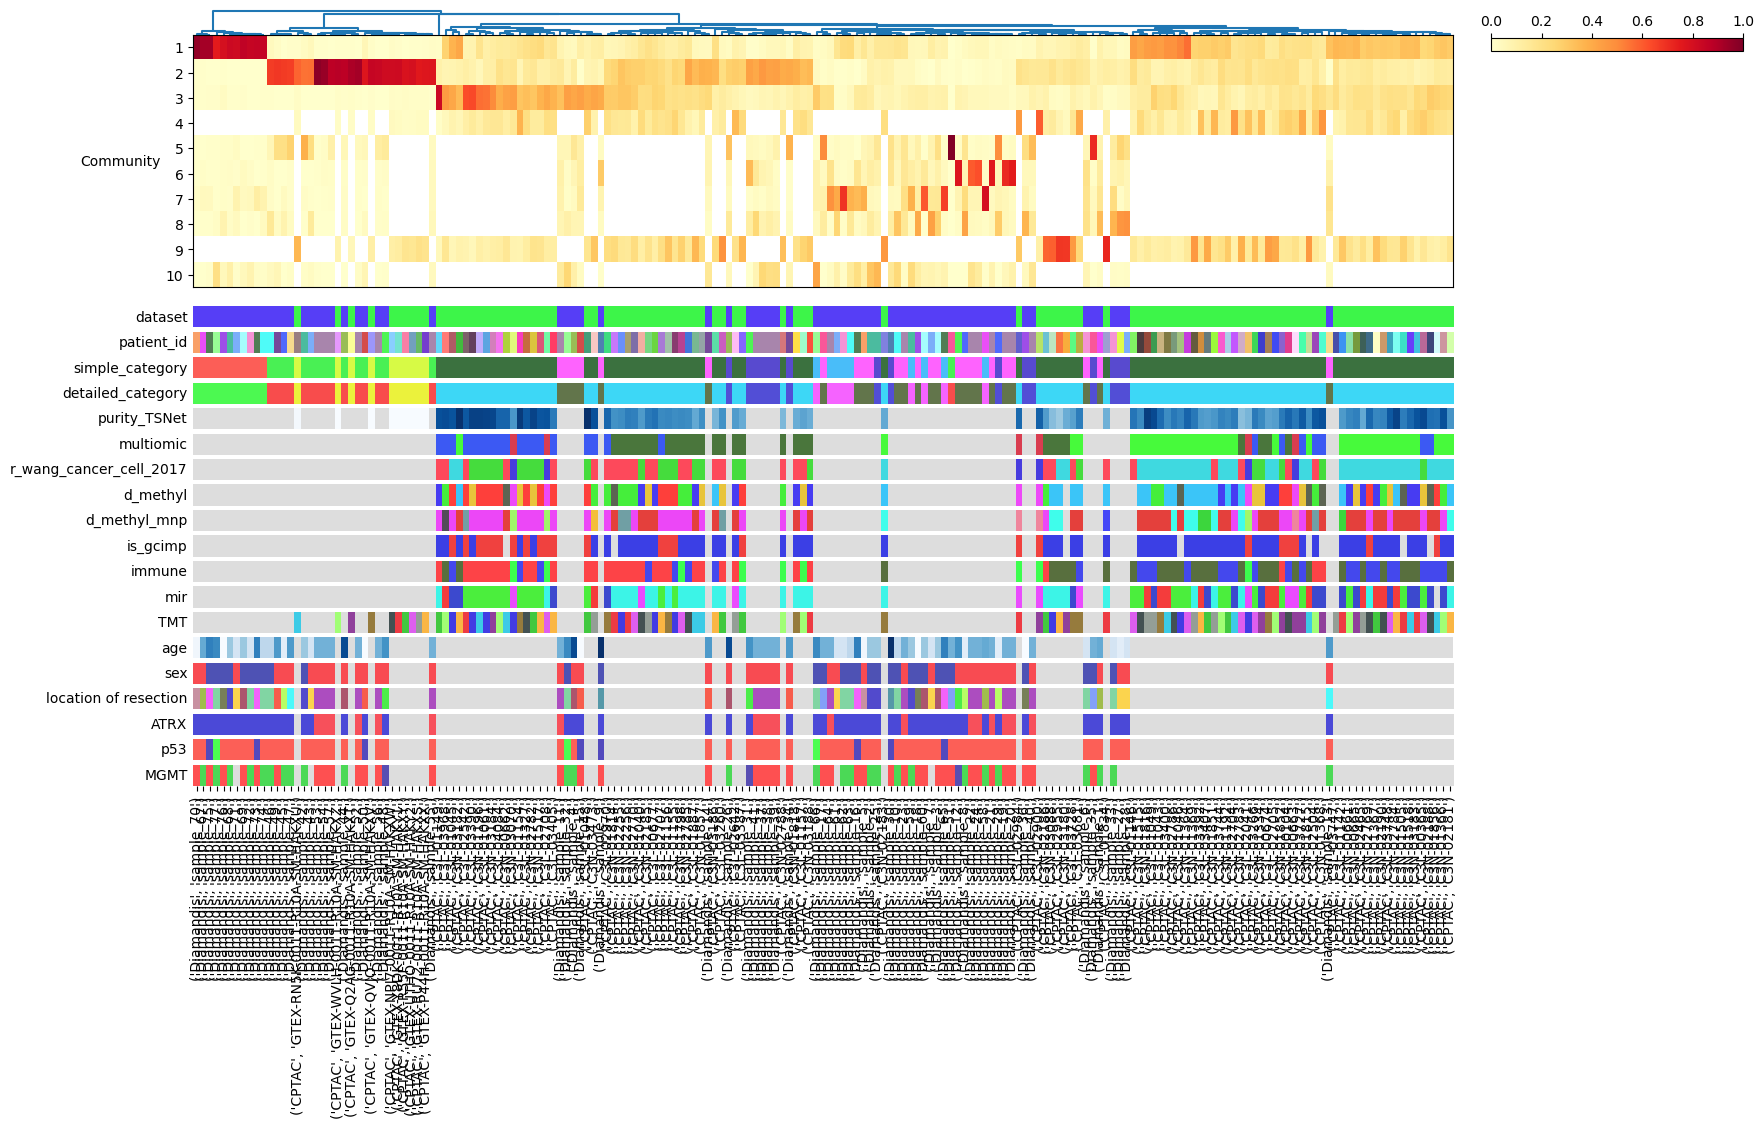

In [33]:
fig = cn.plot_community_usage_heatmap(snsmap, colors, prepend_dataset_colors=True)
# fig_legend = colors.plot_metadata_colors_legend()

## Correlation categorical variables with usage of GEPs, grouped by community

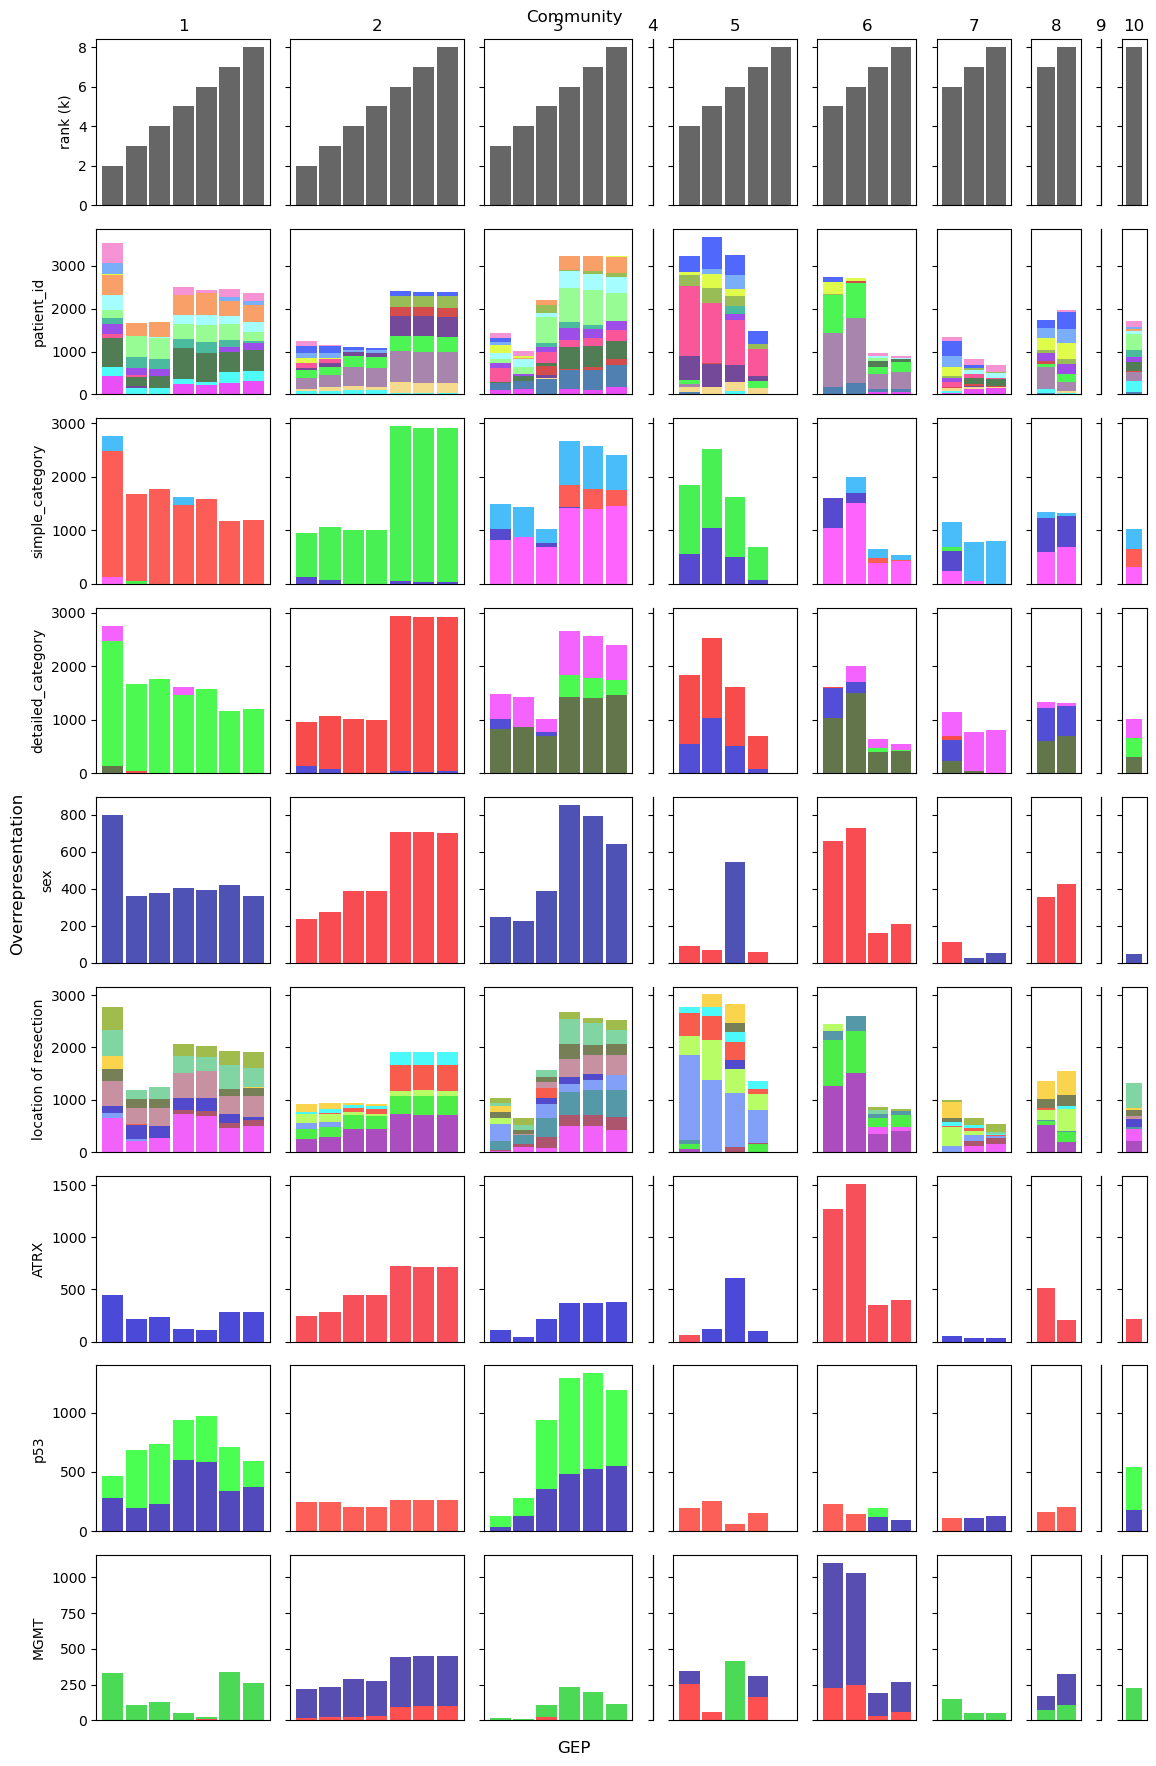

In [34]:
fig = cn.plot_overrepresentation_gep_bar(snsmap, colors, dataset_name="Diamandis")
# fig_legend = colors.plot_metadata_colors_legend()

## Correlation GEPs in each community with continuous variables like `age`

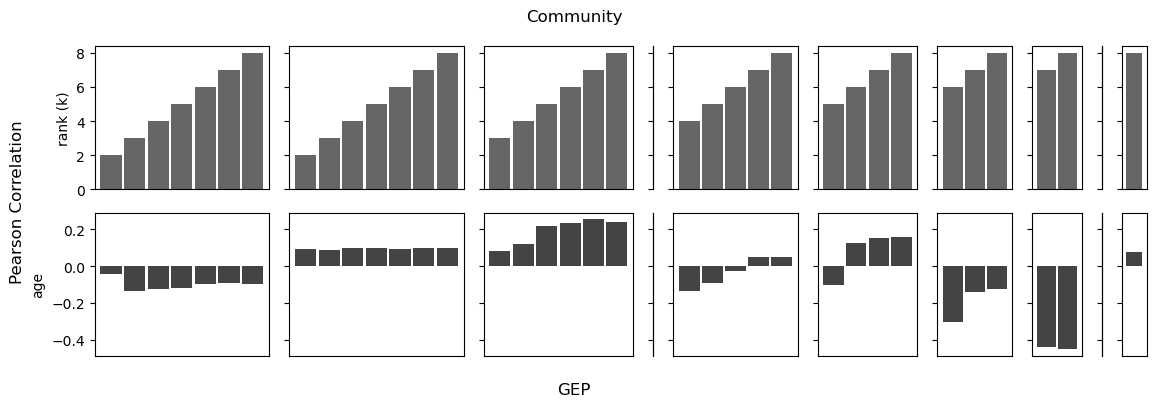

In [35]:
fig = cn.plot_metadata_correlation_gep_bar(snsmap, colors, dataset_name="Diamandis")

# Community-level summary of overrepresentation

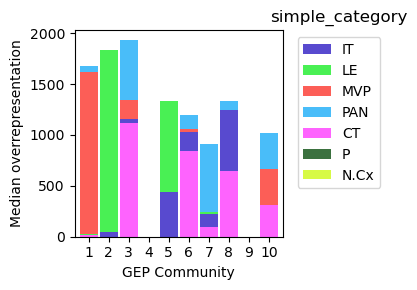

In [36]:
fig = cn.plot_overrepresentation_community_bar(snsmap, colors, layer="simple_category", subset_datasets="Diamandis")

Or, plot it on the network:

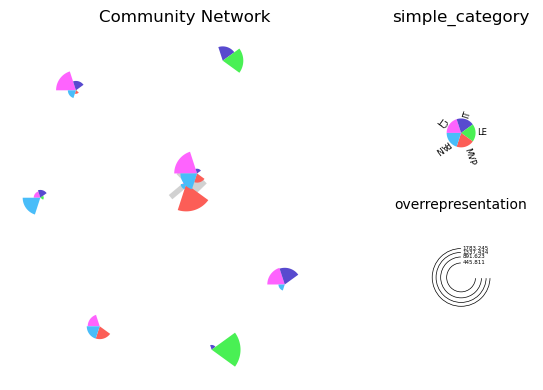

In [37]:
fig = cn.plot_overrepresentation_community_network(snsmap, colors, layer="simple_category", pie_size=0.2, subset_datasets="Diamandis")

# Summarizing correlation with metadata

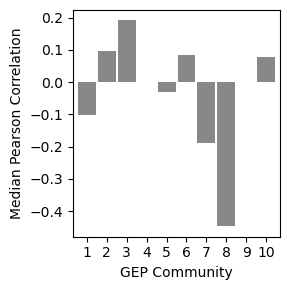

In [38]:
fig = cn.plot_metadata_correlation_community_bar(snsmap, colors, layer="age", subset_datasets="Diamandis")

Or, plot it on the network:

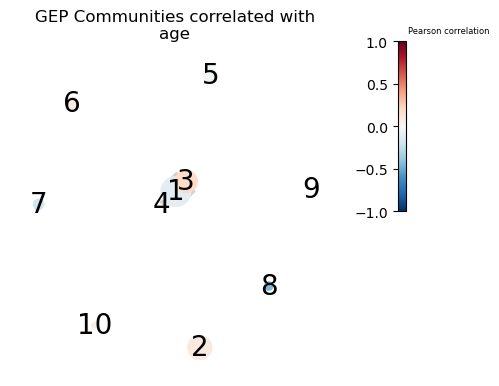

In [39]:
fig = cn.plot_metadata_correlation_community_network(snsmap, colors, layer="age", subset_datasets="Diamandis")

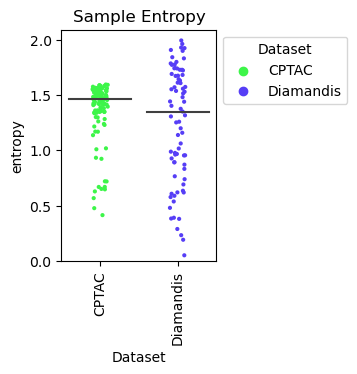

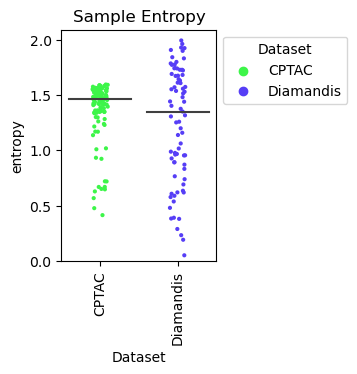

In [40]:
cn.plot_sample_entropy(snsmap, colors)